In [36]:
import blpfunctions as blp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split

def proc_bidask(sec, start, end, quant=0.5):
    event = ['BID','ASK','TRADE']
    bidask = pd.DataFrame()
    for sec in secs:
        bidask=blp.get_Ticks(sec,event,start,end)
        #bidask=bidask.combine_first(df) 

    bidask['ind'] = np.zeros(len(bidask.index))
    bidask['trdind'] = pd.Series(np.nan,index=bidask.index)

    for i in range(len(bidask.index)):
        if bidask['type'][i] == 'BID':
            bidvol = bidask['size'][i]
            bidprc = bidask['price'][i]
        elif bidask['type'][i] == 'ASK':
            askvol = bidask['size'][i]
            askprc = bidask['price'][i]
        elif bidask['type'][i] == 'TRADE':
            if 'askprc' not in vars() or 'bidprc' not in vars():
                continue
            bidask['ind'].iloc[i] = (bidvol - askvol)/(1.0*(askvol + bidvol)) 
            trdvol = bidask['size'][i]
            trdprc = bidask['price'][i]
            if trdprc == askprc:
                bidask['trdind'].iloc[i] = 1
            else:
                bidask['trdind'].iloc[i] = 0
        
    #look at only trades in the top 50%ile, drop first and last trades
    bar = bidask.dropna()
    bar = bar.drop(bar.index[0])
    bar = bar.drop(bar.index[-1])
    foo = bar.loc[bar['size'] > bar['size'].quantile(q=quant)]
   
    #Split the dataset into training and testing
    #Xtrain, Xtest = train_test_split(foo['ind'], test_size = testsize)
    #ytrain, ytest = train_test_split(foo['trdind'], test_size = testsize)
    #Xtrain = pd.DataFrame(Xtrain)
    #Xtest = pd.DataFrame(Xtest)
    
    return pd.DataFrame(foo['ind']), foo['trdind']

secs =['6273 JP Equity']
ind = "NKY Index"
amstart = "2016-04-11T09:00:00"
amend = "2016-04-11T11:30:00" 
pmstart = "2016-04-11T12:30:00"
pmend = "2016-04-11T15:00:00" 

Xtrain, ytrain = proc_bidask(secs, amstart, amend)
Xtest, ytest = proc_bidask(secs, pmstart, pmend)

In [5]:
plt.scatter(foo['ind'],foo['trdind'],s=100*(foo['size']-foo['size'].mean())/foo['size'].std())
plt.show()

KeyError: 'ind'

In [45]:
lg = LogisticRegression()
lg.fit(Xtrain, ytrain)
print(lg)
expected = ytest
predicted = lg.predict(Xtest)

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

Disbursed=lg.predict_proba(Xtest)
fpr, tpr, _ = roc_curve(ytest, Disbursed[:,1])
roc_auc = auc(fpr, tpr)
print roc_auc

def model(x):
    b = lg.intercept_
    m = lg.coef_
    #return 1 / (1 + np.exp(-x))
    return np.exp(b + m*x)/(1 + np.exp(b + m*x))

#loss = model(Xtest.as_matrix() * lg.coef_ + lg.intercept_).ravel()
#plt.plot(Xtest, loss, color='blue', linewidth=3)
xp = pd.DataFrame(np.arange(-1.0,1.1,0.1))
losa = model(xp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
             precision    recall  f1-score   support

        0.0       0.64      0.87      0.74        54
        1.0       0.74      0.43      0.55        46

avg / total       0.69      0.67      0.65       100

[[47  7]
 [26 20]]
0.743357487923


AttributeError: 'RandomForestClassifier' object has no attribute 'intercept_'

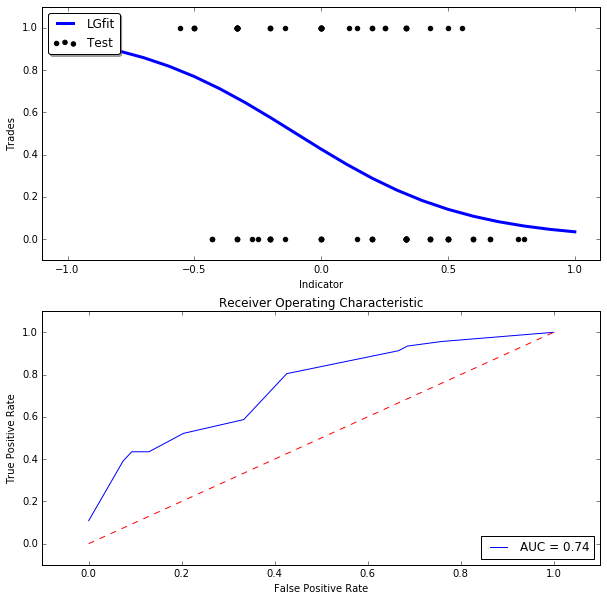

In [43]:
plt.subplots_adjust(hspace=0.6)
f = plt.figure()
f.set_figheight(10)
f.set_figwidth(10)

plt.subplot(211)
plt.plot(xp, losa, color='blue', linewidth=3, label="LGfit")
plt.scatter(Xtest,ytest,color='black',zorder=20, label="Test")
plt.ylabel('Trades')
plt.xlabel('Indicator')
plt.ylim(-0.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.legend(loc=2, shadow=True, fancybox=True)


plt.subplot(212)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
f.savefig("R:\\Users\\4126694\\Python\\Data\\bidask0411-6273.png")

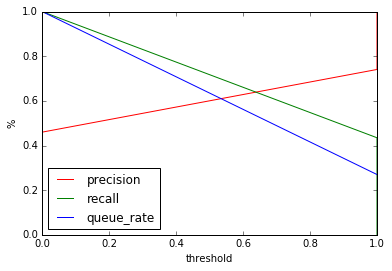

In [44]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(ytest, predicted)
thresholds = np.append(thresholds, 1)

queue_rate = []  
for threshold in thresholds:  
    queue_rate.append((predicted >= threshold).mean())

plt.plot(thresholds, precision, color='r')  
plt.plot(thresholds, recall, color='g')  
plt.plot(thresholds, queue_rate, color='b')

leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True, loc=0)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')  

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, rmsprop

model = Sequential()
model.add(Dense(2, input_shape=(2,), init='uniform', activation ='linear'))
#model.add(Dropout(0.001))
model.add(Dense(12, activation ='sigmoid'))
#model.add(Dropout(0.001))
model.add(Dense(6, activation='hard_sigmoid'))
model.add(Dense(3, activation='hard_sigmoid'))

rms = rmsprop(lr=0.01)
model.compile(optimizer=rms, loss='binary_crossentropy',metrics=['accuracy'])


model.fit(Xtrain.as_matrix(), ytrain, nb_epoch=100, batch_size=256,callbacks=[remote])
score = model.evaluate(Xtest.as_matrix(),ytest, verbose=0)
disb = model.predict_proba(Xtest.as_matrix())

print('Loss Test score:',    score[0])
print('Accuracy Test score:',    score[1])